In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import datasets,models,layers

In [ ]:
from keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

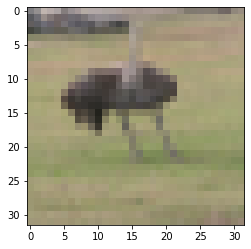

In [ ]:
plt.imshow(X_train[42])

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2,shuffle = True)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(Y_train)
Y_train = encoder.transform(Y_train).toarray()
Y_test = encoder.transform(Y_test).toarray()
Y_val =  encoder.transform(Y_val).toarray()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

Implementacion de la ResNet 18

In [ ]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


In [ ]:
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

#Bloque "Batch Normalizarion"

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)
        
#Observar Tamaños de filtros, polling (entremedio) 
        if self.__down_sample:
            res = self.res_conv(res) 
            res = self.res_bn(res) 

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(256, down_sample=True)#capa añadida 
        self.res_4_2 = ResnetBlock(256)
        self.res_5_1 = ResnetBlock(512, down_sample=True)
        self.res_5_2 = ResnetBlock(512)
        self.res_6_1 = ResnetBlock(256, down_sample=True)#capa añadida 
        self.res_6_2 = ResnetBlock(256)
        self.res_7_1 = ResnetBlock(512, down_sample=True)#capa añadida
        self.res_7_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [ ]:
model = ResNet18(10)
model.build(input_shape = (None,32,32,3))
#use categorical_crossentropy since the label is one-hot encoded
from tensorflow.keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"]) 
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_35 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 resnet_block_14 (ResnetBloc  multiple       

In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_acc")
#I did not use cross validation, so the validate performance is not accurate.
STEPS = len(X_train) / 256
history = model.fit(aug.flow(X_train,Y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs=50, validation_data=(X_train, Y_train),callbacks=[es])

Epoch 1/50
156/156 [==============================] - 34s 207ms/step - loss: 1.5628 - accuracy: 0.4360 - val_loss: 1.8234 - val_accuracy: 0.3438
Epoch 2/50
156/156 [==============================] - 31s 197ms/step - loss: 1.2429 - accuracy: 0.5524 - val_loss: 1.6189 - val_accuracy: 0.4599
Epoch 3/50
156/156 [==============================] - 30s 194ms/step - loss: 1.0901 - accuracy: 0.6112 - val_loss: 1.1530 - val_accuracy: 0.5919
Epoch 4/50
156/156 [==============================] - 33s 214ms/step - loss: 0.9994 - accuracy: 0.6450 - val_loss: 1.2109 - val_accuracy: 0.5831
Epoch 5/50
156/156 [==============================] - 31s 197ms/step - loss: 0.9183 - accuracy: 0.6747 - val_loss: 1.0833 - val_accuracy: 0.6237
Epoch 6/50
156/156 [==============================] - 30s 195ms/step - loss: 0.8735 - accuracy: 0.6885 - val_loss: 0.9689 - val_accuracy: 0.6519
Epoch 7/50
156/156 [==============================] - 32s 203ms/step - loss: 0.8167 - accuracy: 0.7127 - val_loss: 0.7452 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


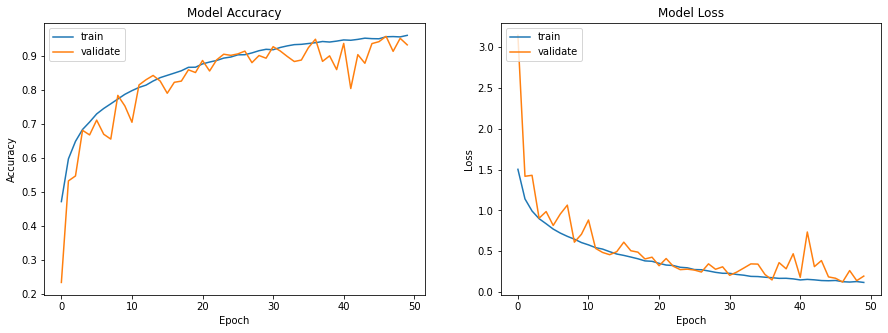

In [ ]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [ ]:
ModelLoss, ModelAccuracy = model.evaluate(X_train, Y_train)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

1250/1250 [==============================] - 14s 11ms/step - loss: 0.0403 - accuracy: 0.9863
Model Loss is 0.04030319303274155
Model Accuracy is 0.9863499999046326
